In [39]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Working through selected parts of the code from the Andrej Karpathy "The spelled-out intro to neural networks and backpropagation: building micrograd" lecture at https://www.youtube.com/watch?v=VMj-3S1tku0. (I'm not taking notes for everything/most things - just occasionally.)

Remember the fundamental that differentiating/taking the derivative or gradient of the end function (like a loss function) w/ respect to something that goes into producing the value of that end function (like a component - call it 'a', or 'b', or 'c') means conceptually answering the question 'how does the end function change when i tweak a, or b, or c by a very small amount. If the answer to this question is positive, then it means that increasing the vallue of the component by a little increases the value of the end function, and if it's negative then it means that increasing the value of the component decreases the value of the end function. (Later, when we're adjusting weights, since we want to minimize loss functions, we negate the value of the gradient in order to change the weight in the correct direction to make the value of the loss function smaller.)

In [37]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''): 
        self.data = data
        self.grad = 0
        self.grad = 0 # what's the deriv of the loss function w/ respect to this value, start at 0 - i.e. no effect
        # track the components that went into creating this value and by what math op, for use in autodiff
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        return out

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = (a * b) + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [21]:
# quickie code to visualize graphs of operations - details not relevant for autograd, see lecture for a bit
from graphviz import Digraph

def trace(root_value):
    # build a set of all nodes and edges in the graph
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root_value)
    return nodes, edges

def draw_dot(root_value):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR is left to right

    nodes, edges = trace(root_value)
    
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

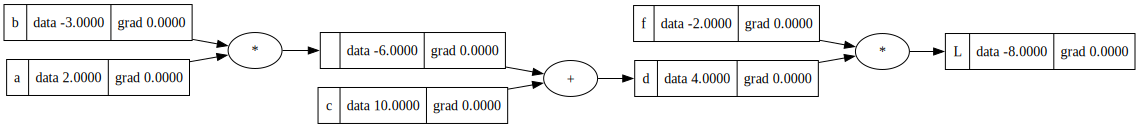

In [24]:
draw_dot(L)

Above, calculating L (i.e., the stand-in for the loss function) is the forward pass. We want to know the derivative of L with respect to each node that leads to L - i.e., how does L change when we tweak f, or d, etc.

We manually calculated the gradients as part of the lecture from around 30m to 60m or so - key thing is the use of what he called the 'local gradient' at the particular node and the gradient of the parent node, multiplying the two together because of the chain rule.

In [20]:
# we can numerically verify grad calc by tweaking the 'with respect to' value and manually calculating the gradient,
# which is the value of the 'gradient of' with a tiny bit added to it minus the value w/o it, normalized by the 
# tiny value - i.e., where h is the tiny bit:
# dL / da = (L2 - L1) / h

def quickie_validation():
    # he put this in a func so it wouldn't change the notebook/global vars

    h = 0.001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = (a * b) + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = (a * b) + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

quickie_validation()

-3.9999999999995595


In [45]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights, for each input
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b') # set so the grad numbers come out nicely
# x1w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [49]:
# manually calculated and set gradients - lecture up to around 1:09, then replaced w/ automatic calcs at 1:09+
o.grad = 1 # how does o change when o changes? proportional, so always start with a grad of 1

n.grad = 0.5

x1w1x2w2.grad = 0.5
b.grad = 0.5

x1w1.grad = 0.5
x2w2.grad = 0.5

x2.grad = w2.data * x2w2.grad # for all of these, for mult, it's the other data * the parent's grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

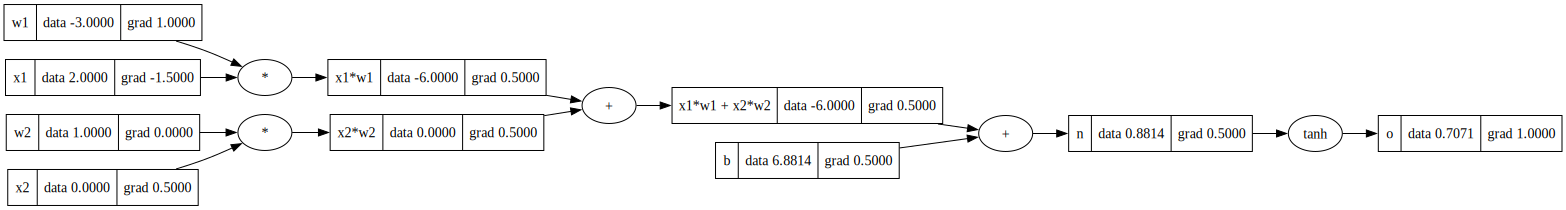

In [50]:
draw_dot(o)